In [1]:
import sys
sys.path.insert(0,'..')

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch as th
import pandas as pd
import os
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro

from bayes.parameters import ParameterList
from bayes.inference_problem import VariationalBayesProblem, ModelErrorInterface
from bayes.Calibration import Inference

from utils.misc import dataloader


# Aim
We have load-displacemnt RAW data as a function of time $t$ for a cylindrical concrete with daimeter $d$.

- Here the parameter to inferred (E) is not known beforehand
- Known Input : $\Sigma(t)$
- Noisy Observed values : $\epsilon(t)$

$$ \epsilon= \frac{1}{E} \Sigma  +  \mathcal{N}(0,\sigma)$$
- To infer : $E$ (Youngs Modulus) and noise hyperparameter $\sigma$

From the experimental data E in the range ~E10

Tasks :
1. Infer postrior from two E mod experiments and use to predict strain for a new experiment

# 1. Reading in the data

Loading in all the experiments and storing in a dict (dataframe). Inferring the latent quantities from two experiments and testing using the third

In [3]:
# Loading data for E-Modulus Wolf specimen 1
path_exp1 = '../usecases/Concrete/Data/E-modul/Wolf 8.2 Probe 1/specimen.dat'
dia_exp1 = 0.0986
height_exp1 = 300.3
idx_s_1 = 330
idx_e_1 = 145
data_exp1 = dataloader(path_exp1,dia_exp1,height_exp1,idx_s_1,idx_e_1)

# Loading data for E-Modulus Wolf specimen 4
path_exp2 = '../usecases/Concrete/Data/E-modul/Wolf 8.2 Probe 4/specimen.dat'
dia_exp2 = 0.0986
height_exp2 = 300.2
idx_s_2 = 335
idx_e_2 = 225
data_exp2 = dataloader(path_exp2,dia_exp2,height_exp2,idx_s_2,idx_e_2)

# Loading data for E-Modulus Wolf specimen 5
path_exp3 = '../usecases/Concrete/Data/E-modul/Wolf 8.2 Probe 5/specimen.dat'
dia_exp3 = 0.0987
height_exp3 = 299.8
idx_s_3 = 320
idx_e_3 = 122
data_exp3 = dataloader(path_exp3,dia_exp3,height_exp3,idx_s_3,idx_e_3)

../utils/misc.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(path, delimiter="\t", skiprows=14, skipfooter=idx_load_end)


In [ ]:
data_exps = pd.concat([data_exp1,data_exp2,data_exp3])

In [ ]:
(np.max(data_exp1['stress'])-np.min(data_exp1['stress']))/(np.max(data_exp1['strain']-np.min(data_exp1['strain'])))

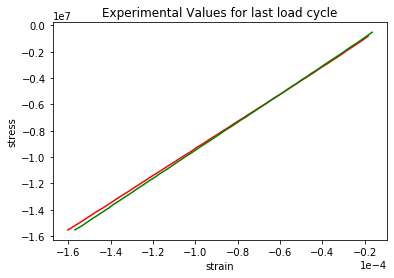

In [17]:
plt.plot(data_exp1['strain'],data_exp1['stress'],'r',label='Exp #1')
plt.plot(data_exp2['strain'],data_exp2['stress'],'g',label='Exp #2')
plt.xlabel('strain')
plt.ylabel('stress')
plt.title('Experimental Values for last load cycle')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:

plt.plot(data_exp1['s'],data_exp1['kN.1'],'r')
plt.plot(data_exp2['s'],data_exp2['kN.1'],'g')
plt.plot(data_exp3['s'],data_exp3['kN.1'],'b')
plt.xlabel('s')
plt.ylabel('load')

In [4]:
# 70-30 training and test split
#train, test = np.split(data_exps.sample(frac=1, random_state=42), 
#                       [int(.7*len(data_exps))])

train = pd.concat([data_exp1,data_exp2])
test = data_exp3

# 2. Forward Solve
Just an algebric relation now. later to be replaced by a differentiable PDE (BAM)

In [5]:
def forward_solve(known_input, latent_para):
    assert isinstance(known_input['known_inputs'],np.ndarray)
    stress = known_input['known_inputs']
    strain = th.tensor(stress)/latent_para
    
    return strain

# 3. Inference Task

Infering the the posterior of E and the noise term.
$$ p(E,\sigma | \mathcal{D}) \propto p(\mathcal{D}|E,\sigma) p(E) p(\sigma) $$
where $\mathcal{D}= \{\Sigma, \epsilon\}$ is the observed data. 

the likelihood $p(\mathcal{D}|E,\sigma)$ is given by $\mathcal{N}(\mathcal{D}|f(\Sigma;E), \sigma)$

- Uniform Prior for the latent variable E
- Gamm hyperprior for the noise term

In [6]:
# -- Metadata for Inference problem
        
prior_hyperparameter = [90E09, 140E09]
prior_dist = "Uniform"
Observed_data = th.tensor(train['strain'].to_numpy())
Noise_distribution = "Normal"
Noise_hyperparameter = None  # TODO: test with correlated noise model
HyperPrior_dist = "Gamma"
Hyperprior_Parameter = [1,1E05]

 # ---- Metadata for forward solve
forward_solve_wrapper = forward_solve
forward_solve_known_input = train['stress'].to_numpy()
forward_input = {'known_inputs':forward_solve_known_input}

# -- Setup the Inference problem
infer = Inference(prior_dist, prior_hyperparameter, forward_solve_wrapper, forward_input, Observed_data,
                  Noise_distribution, Noise_hyperparameter,HyperPrior_dist,Hyperprior_Parameter)

# -- Solve the Inference problem
No_samples = 1000
posterior_samples = infer.run(No_samples, kernel="NUTS")

Sample: 100%|██████████| 2000/2000 [00:09, 208.51it/s, step size=8.32e-01, acc. prob=0.914]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta 95138479839.95 463221470.45 95134385054.38 94360709999.34 95860422203.42    979.82      1.00
     sigma      0.00      0.00      0.00      0.00      0.00    775.14      1.01

Number of divergences: 0


In [ ]:
# The strain values are very small. Need to normalize? What noise hyperprior dist? Their parameters?

## 3.1 Inference Visualisation 

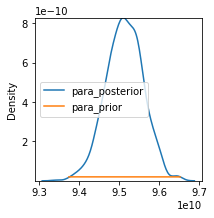

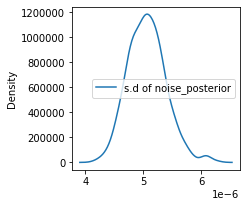

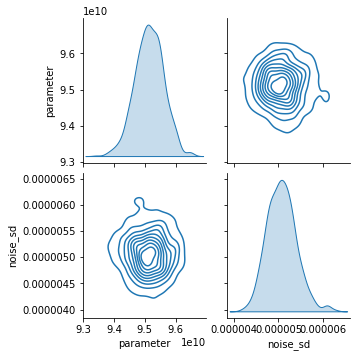

In [8]:
infer.visualize_prior_posterior(posterior_samples,pairplot=True)

# 4. Prediction

$$ \epsilon= \frac{1}{E} \Sigma  + \sigma \mathcal{N}(0,1)$$
The additive noise can be from the sensors or from model bias. As reported model bias is more more dominant than the sensor noise. The module provides an option to switch between those two. 

Let $\hat{Y}$ be new datapoint for which probabilsitic predictions needs to be done. Let $Y$ be the observed/given data and $\theta$ be the latent parameter. Then the posterior predictive is given by:

$$p(\hat{Y}|Y) = \int p(\hat{Y}|\theta) p(\theta|Y) d\theta$$

This can be approximated by Monte carlo. In the current example the general terms are $(\hat{Y} : \hat{\epsilon}, \theta : E, Y : \epsilon) $

So $p(\theta|Y)$ is the posterior inferred above. The MAP point of the noise s.d $\sigma$ is taken. Note that if the noise term is considered just as sensor noise, then $p(\hat{Y}|\theta)$ is replaced by the forward solver i.e, $\hat{Y} = f(\hat{X})$ (here X would be the stress/load), if its model bias then $p(\hat{Y}|\theta) = f(\hat{X}) + \mathcal{N}(0,\sigma)$





In [13]:
# known input 
tmp = test['stress'].to_numpy() # AA: Can write a wrapper to read in data if they are in same order (maybe for similar experiment), can also imporrt data from different experiment of the similar specimen
new_input_forward = {'known_inputs': tmp}

til_Y = infer.predict(posterior_samples,new_input_forward,model_discrepancy=True)

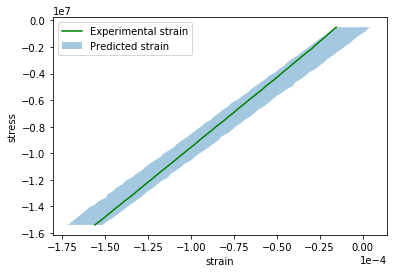

In [14]:
infer.visualize_predictive_posterior(til_Y,test)

# Misc

In [ ]:

sampled_parameters = pyro.sample('test', dist.Normal(0, 1))

In [ ]:
for name,value in sampled_parameters:
    print(name,value)

In [ ]:
sampled_parameters.items()

In [ ]:
import pyro 
import pyro.distributions as dist
import torch as th

mean = [1.0, 2.0]

cov = [[1., 0.],
       [0., 1.]]

pyro.sample('test', dist.Normal(th.tensor([1.,2.,3.]),1.))

In [ ]:
mean = np.ones(5)

In [ ]:
th.tensor(mean)

In [ ]:
cov